# Exploratory Data Analysis

In the part of data storytelling, we have already explored the evolvement of trend in various attribute throughout about 40 years in each position, including PTS(number of points), 3PA(number of 3-pointer attempts), 
2PA(number of 2-pointer attempts), AST(number of assists), FT(number of free throws), etc. 

In this section we are going to use statistical analysis to validate if some of the observations are true.

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import seaborn as sns

### Open cleansed dataset

In [25]:
with open('data/Seasons_Stats_cleansed.csv') as csvfile:
    reader1 = csv.reader(csvfile)
data = pd.read_csv('data/Seasons_Stats_cleansed.csv',sep='\t')

### Divide the dataset according to positions and time periods

As It is in the previous section, we will divided the cleansed data set into groups according to positions, and also into four different time periods.

In [26]:
pg = data[data['Pos'] == 'PG']
sg = data[data['Pos'] == 'SG']
sf = data[data['Pos'] == 'SF']
pf = data[data['Pos'] == 'PF']
c = data[data['Pos'] == 'C']

In [27]:
pre90s = data[~(data['Year']>1989)]
_90s = data[~(data['Year']<1990) & ~(data['Year']>1999)]
_00s = data[~(data['Year']<2000) & ~(data['Year']>2009)]
_10s = data[~(data['Year']<2010)]

## Statistical analysis on scoring points(PTS) data

We have already observed the change of role in leading the scoring data among the positions. Before 1990, players of SG had the highest number in scoring point, and according to the visualization we think SG players have been scoring less, so we will use statistical analysis to validate this observation.

### Select SG dataset from two different periods

Since we want to compare the scoring data of SG from early and recent periods, I choose to use the data before 1990s and after 2010s. 

In [28]:
sg_pre90s = pre90s[pre90s['Pos'] == 'SG']
sg_10s = _10s[_10s['Pos'] == 'SG']

In [29]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

Plot the ECDFs for the average scoring points for SG before 1990s and after 2010s on the same plot.

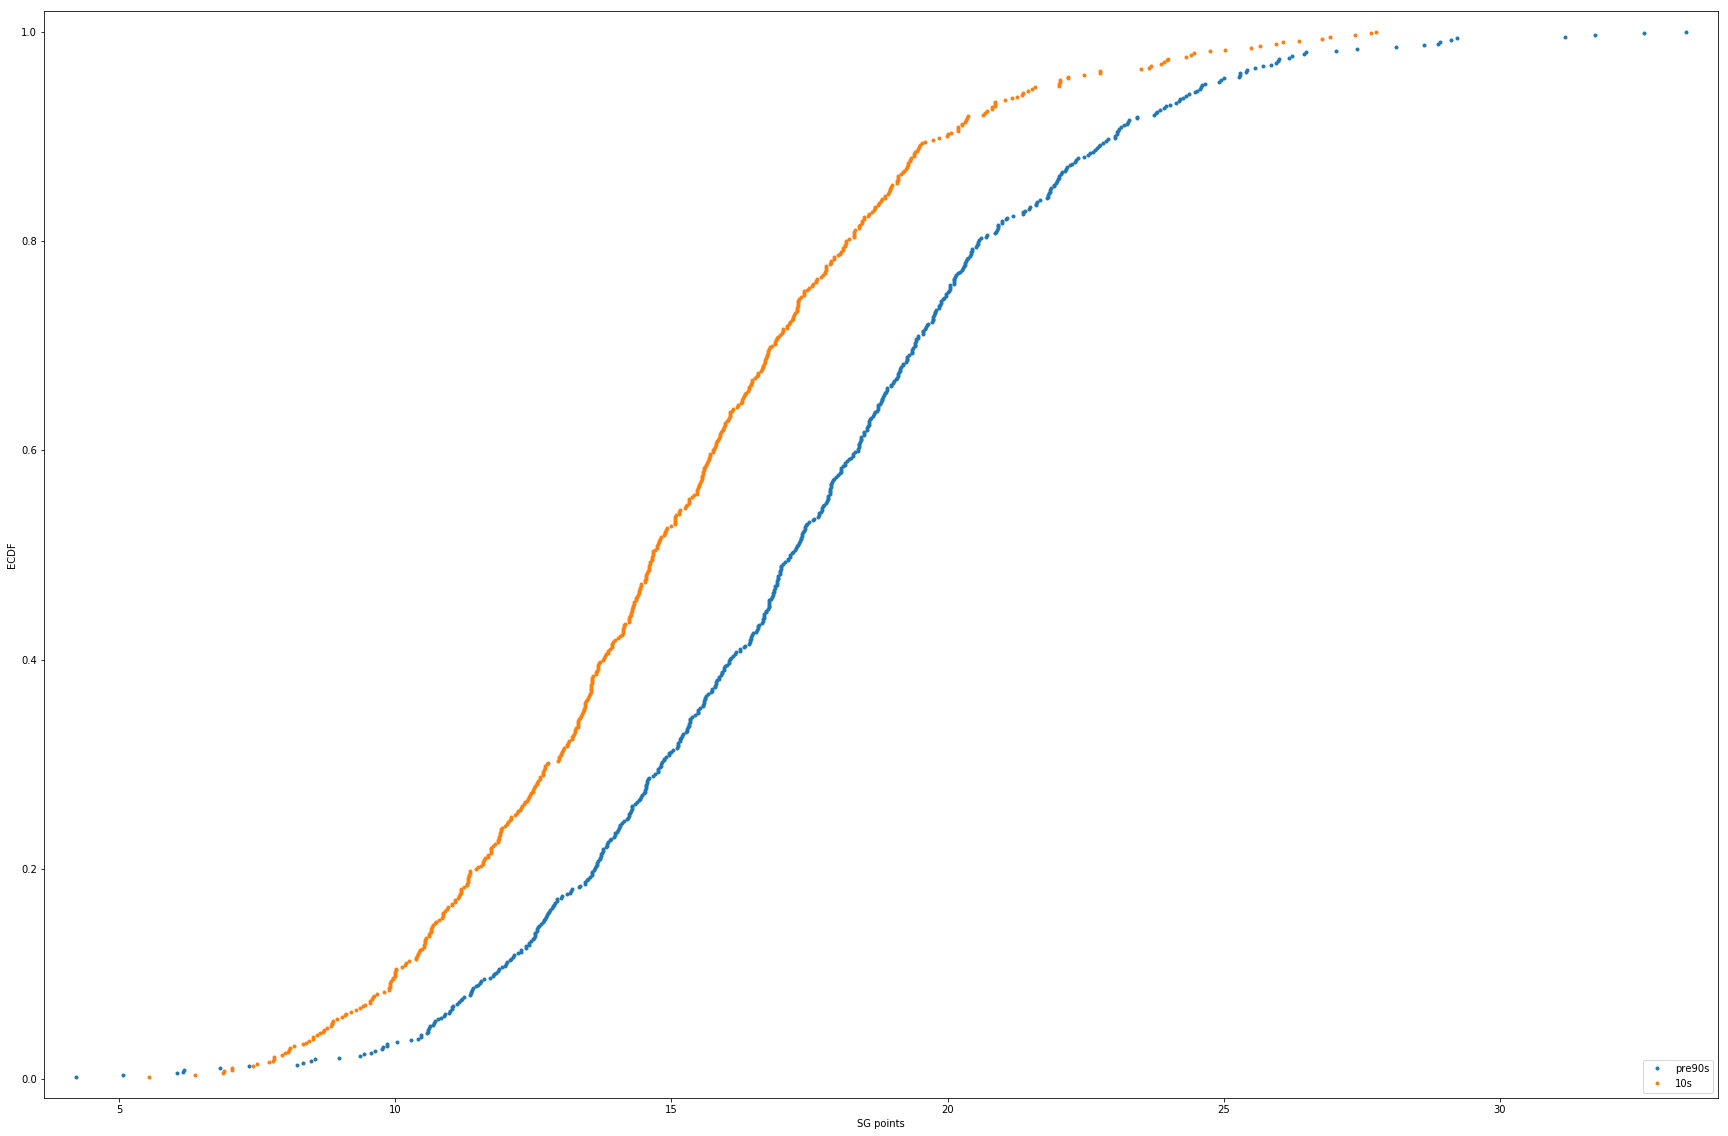

In [30]:
# Compute ECDFs
x_sg_pre90s, y_sg_pre90s = ecdf(sg_pre90s['PTS'])
x_sg_10s, y_sg_10s = ecdf(sg_10s['PTS'])

plt.figure(figsize=(30,20))

# Plot the ECDFs
_ = plt.plot(x_sg_pre90s, y_sg_pre90s, marker='.', linestyle='none')
_ = plt.plot(x_sg_10s, y_sg_10s, marker='.', linestyle='none')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('SG points')
_ = plt.ylabel('ECDF')
_ = plt.legend(('pre90s', '10s'), loc='lower right')

# Show the plot
plt.show()

We can see that the differences of scoring data for SG in two different times are much clearer in the ECDF. The mean scoring number is larger at around 17 before 1990s, and the variance does appear larger as well, as it stretches from 1 to well above 30, while for the data in 2010s with lower mean at around 15, only ranges from 1 to slightly above 25.

### Preform hypothesis test

In [31]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    # Store the replicate in the appropriate index of bs_replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates


H0: p = 0 H1: p ≠ 0

#### Null hypothesis: 
There is no difference between the scoring points of SG before 1990 and after 2010
(average scoring points difference is 0, p = 0)

#### Alternate hypothesis: 
There is difference between the scoring points before 1990 and after 2010
(average scoring points difference is not 0, ρ≠0)


To perform this hypothesis test, we need to shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.


In [34]:
mean_diff = np.mean(sg_pre90s['PTS']) - np.mean(sg_10s['PTS'])

print('difference of means =', mean_diff, 'pts')

# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((sg_pre90s['PTS'], sg_10s['PTS'])))

# Shift the samples
sg_pre90s_shifted = sg_pre90s['PTS'] - np.mean(sg_pre90s['PTS']) + combined_mean
sg_10s_shifted = sg_10s['PTS'] - np.mean(sg_10s['PTS']) + combined_mean

# Get bootstrap replicates of shifted data sets
sg_replicates_pre90s = draw_bs_reps(sg_pre90s_shifted, np.mean, 10000)
sg_replicates_10s = draw_bs_reps(sg_10s_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
sg_diff_replicates = sg_replicates_pre90s - sg_replicates_10s

# Compute the p-value: p
p = np.sum(sg_diff_replicates >= mean_diff) / len(sg_diff_replicates)

# Print p-value
print('p =', p)

difference of means = 2.314349357039598 pts
p = 0.0


We get a p-value of 0.0, which suggests that there is a statistically significant difference. We got a difference of 2.314 points between the means. You should combine this with the statistical significance. Changing by 2.314 points in 40 years is substantial. 